The following script was made written by Jens Bager Christensen (jbc53@cam.ac.uk) to perform _in silico_ gene regulatory network reconstruction using pySCENIC in relation to the publication Christensen et al., 2025. For further information see [the vignette ](https://pyscenic.readthedocs.io/en/latest/) or see the related [publication](https://www.nature.com/articles/s41596-020-0336-2).



In [ ]:
#import packages required for pySCENIC
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

In [ ]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 40

In [ ]:
#set directories for necessary input databases and output locations
RESOURCES_FOLDERNAME = "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/database/pySCENIC/resources/"
AUXILLIARIES_FOLDERNAME = "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/database/pySCENIC/auxilliaries/"
RESULTS_FOLDERNAME = "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/"
FIGURES_FOLDERNAME = "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/pySCENIC_figures/"
sc.settings.figdir = FIGURES_FOLDERNAME

In [ ]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [ ]:
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(FIGURES_FOLDERNAME, fname), format='svg')

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [ ]:
# Downloaded fromm pySCENIC github repo: https://github.com/aertslab/pySCENIC/tree/master/resources
HUMAN_TFS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'mm_mgi_tfs.txt')
# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       ['mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
                        'mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather']))
# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl')

In [ ]:
DATASET_ID = "WM_NEPs"
TCGA_CODE = 'JBC'

In [ ]:
#Load the data
adata = sc.read_h5ad("/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/h5ad/nonIR_bifurcation_NEPs.h5ad")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/h5ad/nonIR_bifurcation_NEPs.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

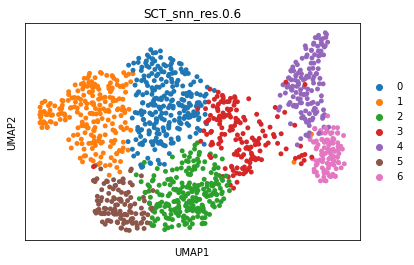

In [ ]:
#check out the data in a UMAP
#make clusters a categorical variable
adata.obs["SCT_snn_res.0.6"] = adata.obs["SCT_snn_res.0.6"].astype('category')

#plot umap
sc.pl.umap(adata, layer='umap', color="SCT_snn_res.0.6")


In [ ]:
#defining directories
METADATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.metadata.csv'.format(DATASET_ID))
EXP_MTX_QC_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.qc.tpm.csv'.format(DATASET_ID))
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}_{}.loom'.format(TCGA_CODE, DATASET_ID))

In [ ]:
#define the meta data
df_metadata = adata.obs

#translate the variable (feature) names from Ensembl IDs into gene symbols
#read in the gene symbols
bifurcation_gene_symbols = pd.read_csv("./data/bifurcation_features_gene_symbols.txt")
#add them as .var_obs
adata.var_names = bifurcation_gene_symbols["adata@assays$RNA[[]]$gene_name"]

#define expression matrix
df_tpm = adata.X

#save the expression matrix as a txt file, because it required for running grn
adata.to_df().to_csv(EXP_MTX_QC_FNAME)

#create loom file of the 5had object. Run this only once.
import loompy as lp
row_attrs = {
"Gene": np.array(adata.var_names),
}
col_attrs = {
"CellID": np.array(adata.obs_names),
"nGene": np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(),
"nUMI": np.array(np.sum(adata.X.transpose(),axis=0)).flatten(),
}
lp.create("nonIR_bifurcation_NEPs.loom",adata.X.transpose(),row_attrs,
col_attrs)

In [ ]:
#Because the GRNBoost2 algorithm performs a repeated random subsamplings of genes to effectively model the expression of a given target gene based on a set of TFs, the output varies slightly between runs. 
#To overcome this stochastic nature we ran the entire analysis pipeline 10 times to ensure robust results.   

#Perform the the network inference using the GRNBoost2 algorithm. Performed in the CLI.
    #for i in {1..10}; do pyscenic grn "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/nonIR_bifurcation_NEPs.loom" "/mnt/beegfs6/home3/bayin/jbc53/SCENIC/Databases/allTFs_mm.txt" -o "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcation_NEPs_adjacencies_$i.tsv" --num_workers 40; done

#compute candidate regulon generation and regulon prediction. Performed in the CLI.
    #for i in {1..10}; do pyscenic ctx "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_adjacencies_$i.tsv" "/./mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/database/pySCENIC/auxilliaries/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather" --annotations_fname "/./mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/database/pySCENIC/auxilliaries/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl" --expression_mtx_fname "/./mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/nonIR_bifurcation_NEPs.loom" --output "/./mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcation_NEPs_motifs_$i.csv" --num_workers 40; done

#Motif matrices can be browsed with the following line
df_motifs = load_motifs('/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcation_NEPs_motifs_4.csv')

#display_logos(df_motifs.head())

In [ ]:
#deriving the regulons
regulons = df2regulons(df_motifs)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [ ]:
#calculating regulon enrichment by calculating area under curve of genes that define the regulons. Performed in the CLI.
    #for i in {1..10}; do pyscenic aucell "/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/data/nonIR_bifurcation_NEPs.loom" "/./mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcation_NEPs_motifs_$i.csv" --output "/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_$i.loom" --num_workers 30; done

In [ ]:
#read in all the output loom files to investigate their enrichment in different clusters

import loompy as lp
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_1.loom", mode='r+', validate=False)
auc_mtx_1 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx.head)

#Load all the GRNs from every run
#2
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_2.loom", mode='r+', validate=False)
auc_mtx_2 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_2.head)

#3
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_3.loom", mode='r+', validate=False)
auc_mtx_3 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_3.head)

#4
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_4.loom", mode='r+', validate=False)
auc_mtx_4 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_4.head)

#5
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_5.loom", mode='r+', validate=False)
auc_mtx_5 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_5.head)

#6
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_6.loom", mode='r+', validate=False)
auc_mtx_6 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_6.head)

#7
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_7.loom", mode='r+', validate=False)
auc_mtx_7 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_7.head)

#8
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_8.loom", mode='r+', validate=False)
auc_mtx_8 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_8.head)

#9
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_9.loom", mode='r+', validate=False)
auc_mtx_9 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_9.head)

#10
lf = lp.connect("/mnt/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/nonIR_bifurcaation_NEPs_pySCENIC_10.loom", mode='r+', validate=False)
auc_mtx_10 = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
#print(auc_mtx_10.head)

In [ ]:
#a dataframe is constructed combining the output auc matrices from each run into a single dataframe. 
#If a regulon appears in multiple runs, the average activity of the regulon is taken.
dataframes = [auc_mtx_1, auc_mtx_2, auc_mtx_3, auc_mtx_4, auc_mtx_5,
              auc_mtx_6, auc_mtx_7, auc_mtx_8, auc_mtx_9, auc_mtx_10]

# Step 1: Rename columns in each dataframe temporarily to preserve uniqueness
for i, df in enumerate(dataframes):
    dataframes[i] = df.add_suffix(f'_{i}')

# Step 2: Concatenate the dataframes along columns
combined_df = pd.concat(dataframes, axis=1)

# Step 3: Melt combined_df to create a long format for easy grouping and averaging
long_df = combined_df.melt(ignore_index=False, var_name="column", value_name="value")

# Step 4: Extract the original column names by removing suffixes
long_df['original_column'] = long_df['column'].str.extract(r'(.+)_\d+$', expand=False)

# Step 5: Group by index and the original column name, then take the mean
final_df = long_df.groupby([long_df.index, "original_column"])['value'].mean().unstack()

add_scenic_metadata(adata, final_df) 

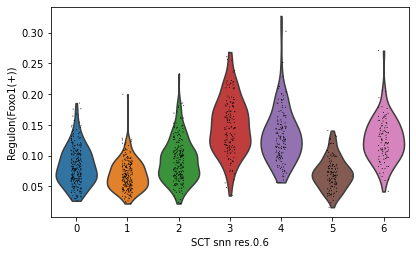

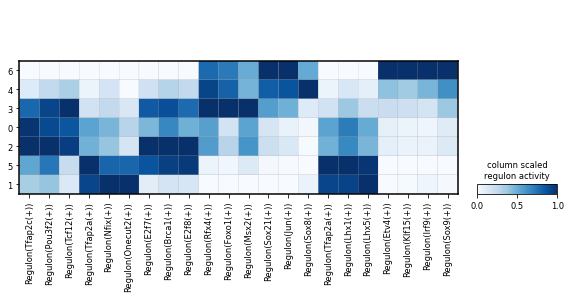

In [ ]:
#The regulons that most robustly appear among the top 5 most specific regulon in a clusters are compiled.
#top regulons
top_regulons = ["Regulon(Tfap2c(+))", "Regulon(Pou3f2(+))", "Regulon(Tcf12(+))","Regulon(Tfap2a(+))","Regulon(Nfix(+))","Regulon(Onecut2(+))","Regulon(E2f7(+))","Regulon(Brca1(+))",
                "Regulon(E2f8(+))","Regulon(Rfx4(+))","Regulon(Foxo1(+))","Regulon(Msx2(+))","Regulon(Sox21(+))","Regulon(Jun(+))","Regulon(Sox8(+))","Regulon(Tfap2a(+))","Regulon(Lhx1(+))",
                "Regulon(Lhx5(+))","Regulon(Etv4(+))","Regulon(Klf15(+))","Regulon(Irf9(+))"]

#alternatively, visualise the top regulons including the SOX9 regulon.
top_regulons_sox9 = ["Regulon(Tfap2c(+))", "Regulon(Pou3f2(+))", "Regulon(Tcf12(+))","Regulon(Tfap2a(+))","Regulon(Nfix(+))","Regulon(Onecut2(+))","Regulon(E2f7(+))","Regulon(Brca1(+))",
                "Regulon(E2f8(+))","Regulon(Rfx4(+))","Regulon(Foxo1(+))","Regulon(Msx2(+))","Regulon(Sox21(+))","Regulon(Jun(+))","Regulon(Sox8(+))","Regulon(Tfap2a(+))","Regulon(Lhx1(+))",
                "Regulon(Lhx5(+))","Regulon(Etv4(+))","Regulon(Klf15(+))","Regulon(Irf9(+))", "Regulon(Sox9(+))"]

#visualise as a heatmap
sc.pl.matrixplot(
    adata,
    top_regulons,
    "SCT_snn_res.0.6",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nregulon activity",
    categories_order = [6, 4, 3, 0, 2, 5, 1]
)

In [ ]:
#calculating the RSS for every pySCENIC run
rss_1 = regulon_specificity_scores(auc_mtx_1, adata.obs["SCT_snn_res.0.6"])

#The RSS outputs are exported
#rss_1.to_excel("/mnt/beegfs6/home3/bayin/jbc53/scRNA-seq_2023/Christensen_et_al_2024/results/pySCENIC_figures/RSS_output_1.xlsx")

,Atf3(+),Atoh1(+),Bach2(+),Barhl1(+),Bptf(+),Brca1(+),Cebpb(+),Cebpd(+),Creb5(+),Cux1(+),...,Tfdp2(+),Uncx(+),Yy1(+),Zeb1(+),Zfp467(+),Zfp553(+),Zfp580(+),Zfp78(+),Zfp91(+),Zscan25(+)
1,0.304151,0.314655,0.367442,0.369318,0.343439,0.306210,0.306554,0.310013,0.327604,0.333792,...,0.337485,0.367362,0.338847,0.338107,0.319871,0.369719,0.346266,0.360542,0.322766,0.333335
4,0.337892,0.273994,0.269741,0.285684,0.281048,0.269792,0.333963,0.319504,0.317615,0.281131,...,0.282720,0.275468,0.287053,0.298737,0.315608,0.268947,0.286674,0.273838,0.284608,0.230294
0,0.312838,0.340655,0.331000,0.336495,0.356439,0.358681,0.327703,0.326322,0.328683,0.356264,...,0.364062,0.350406,0.358358,0.349368,0.330630,0.319015,0.357842,0.339695,0.344157,0.278126
2,0.309132,0.341554,0.312659,0.321540,0.330571,0.364475,0.310381,0.309532,0.316934,0.344172,...,0.342167,0.329739,0.340412,0.331147,0.309445,0.308747,0.333041,0.330915,0.343615,0.257747
6,0.314314,0.236429,0.235029,0.250992,0.248731,0.230132,0.323093,0.340064,0.277709,0.251210,...,0.243506,0.245480,0.247127,0.257327,0.322494,0.266416,0.253089,0.244205,0.262537,0.209223
5,0.248193,0.277039,0.280180,0.285524,0.271180,0.286772,0.244126,0.249757,0.261941,0.277364,...,0.272503,0.283941,0.274875,0.268994,0.251683,0.285032,0.273351,0.288015,0.279018,0.261987
3,0.308781,0.295138,0.282242,0.289752,0.301978,0.314726,0.302386,0.293972,0.303904,0.300900,...,0.302507,0.291176,0.297420,0.300736,0.300889,0.282751,0.297075,0.285313,0.305112,0.237356


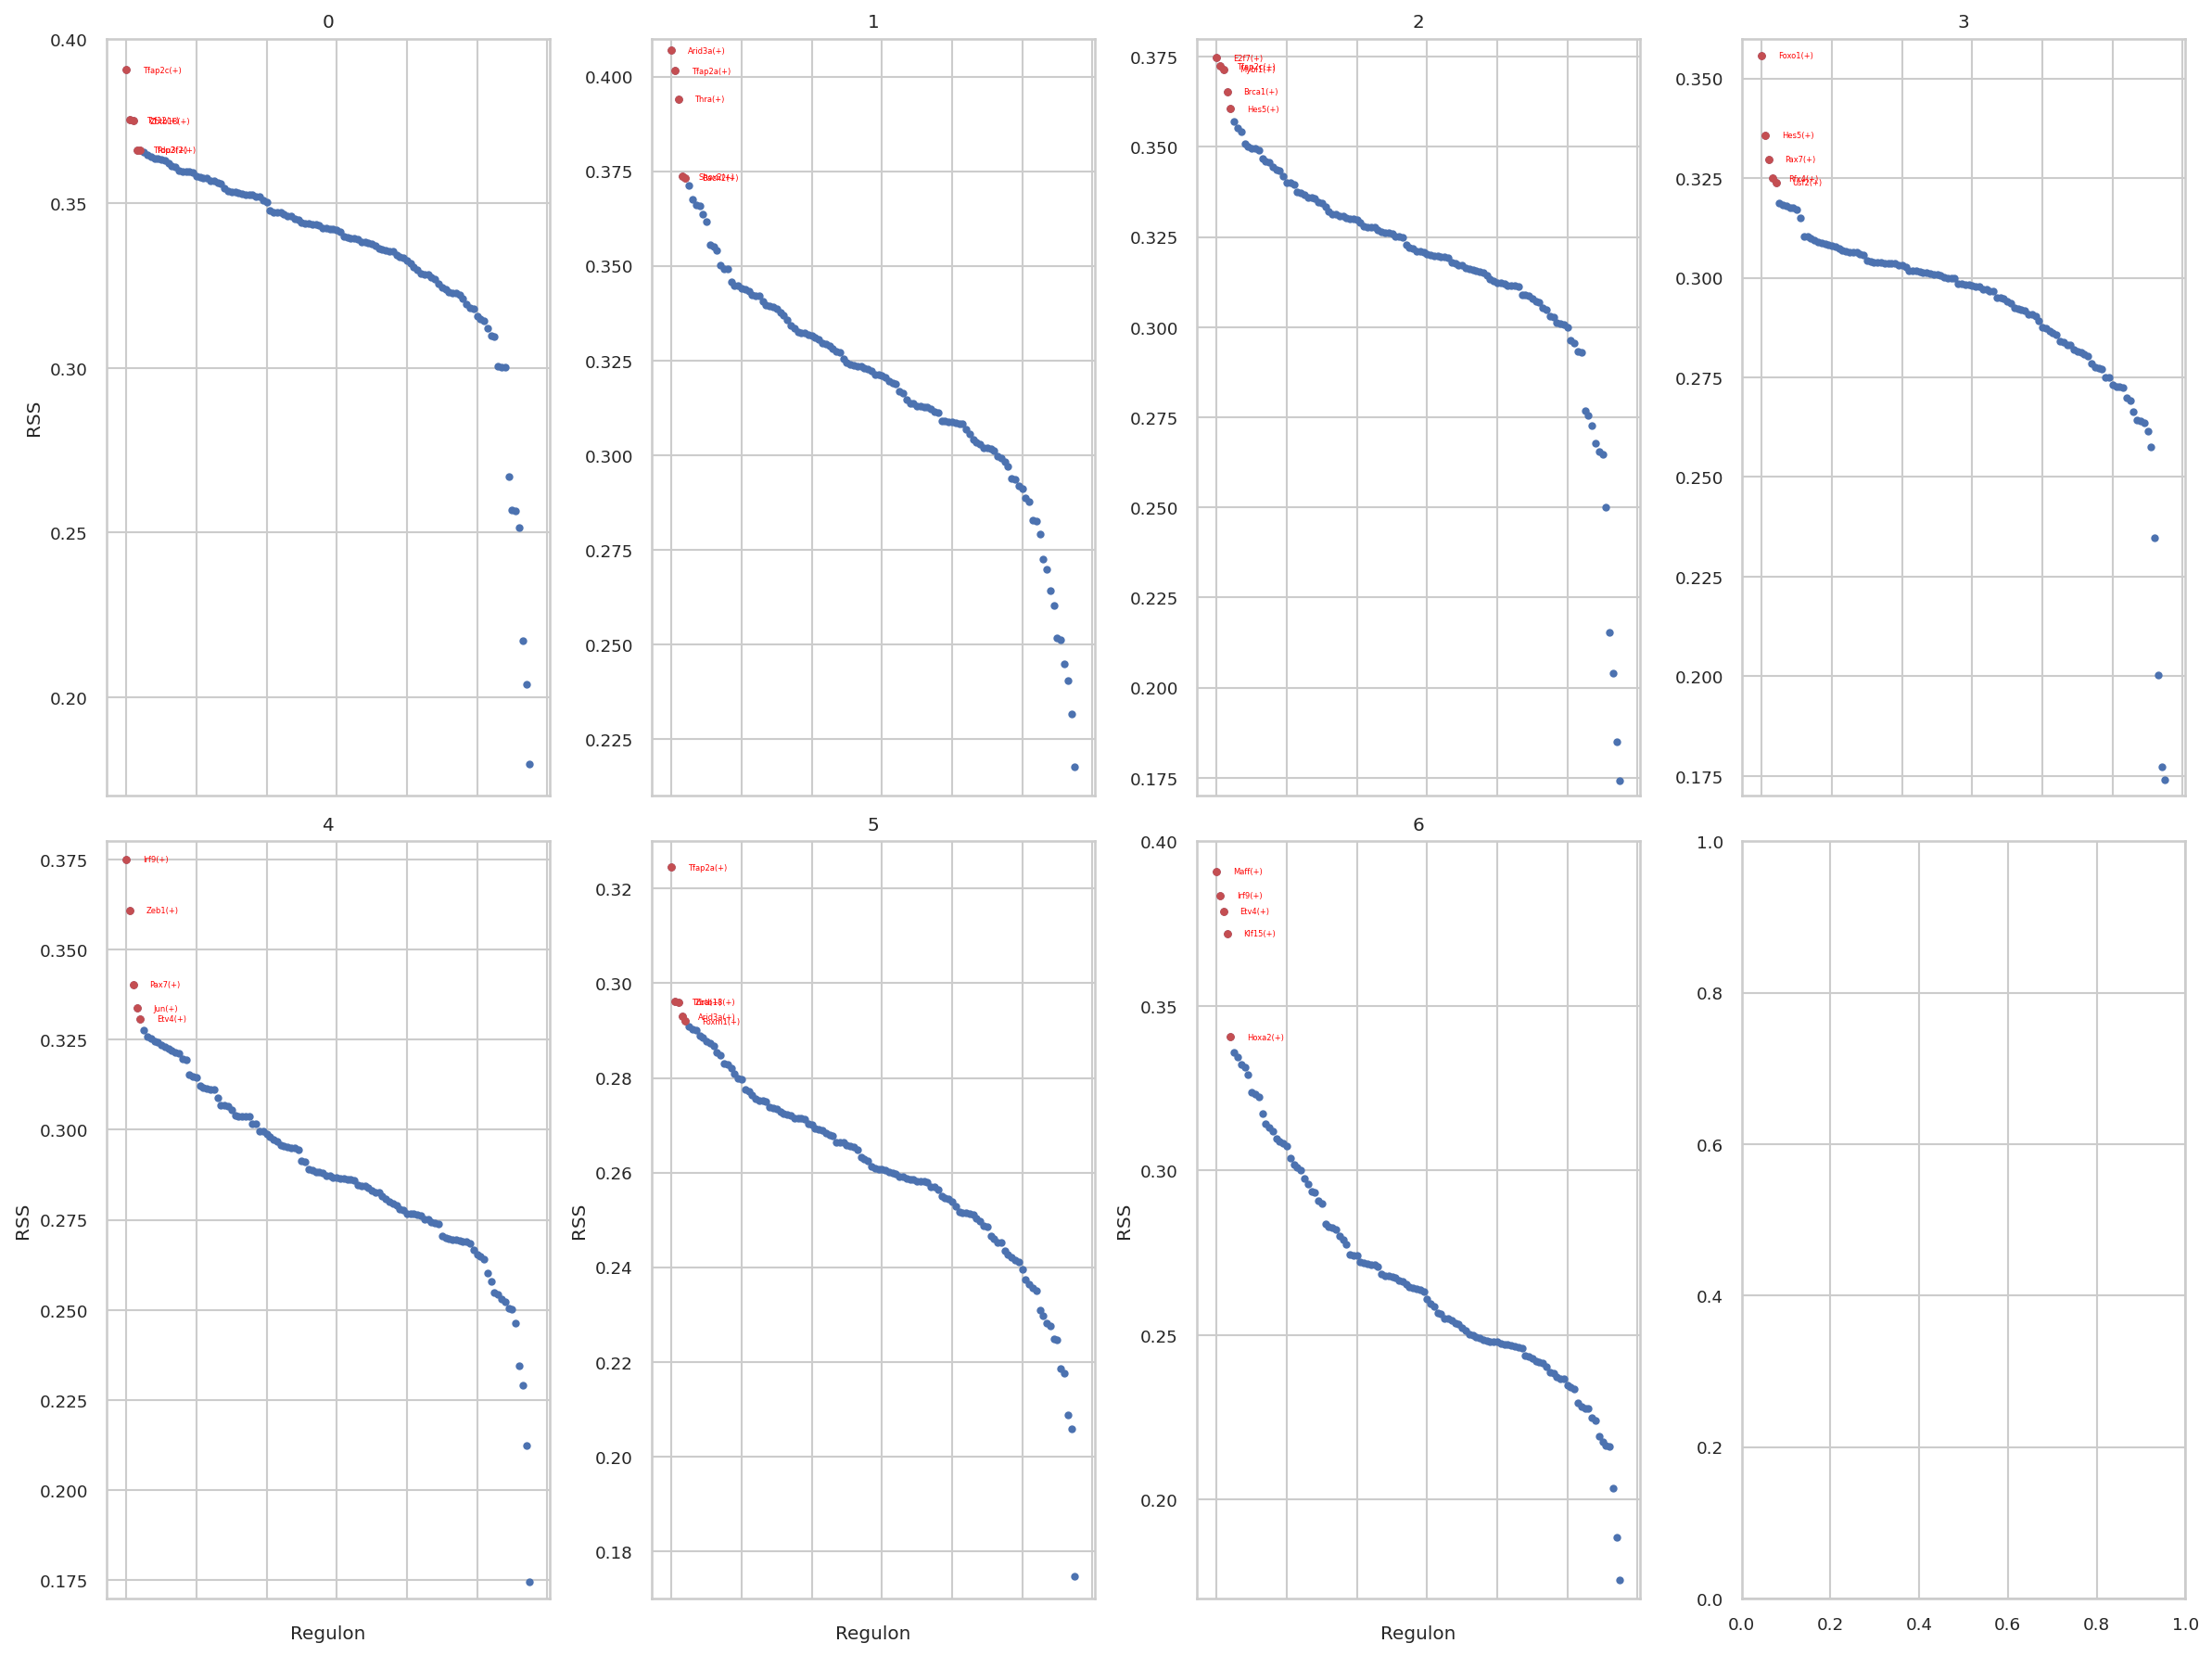

In [ ]:
#plot the specificity score for regulons in the different clusters.
rss = regulon_specificity_scores(auc_mtx_9, adata.obs["SCT_snn_res.0.6"])

#visualise specificity score plots
sns.set()
sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 12), dpi=150)
plot_rss(rss, 0, ax=ax1)
ax1.set_xlabel('')
plot_rss(rss, 1, ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
plot_rss(rss, 2, ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
plot_rss(rss, 3, ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('')
plot_rss(rss, 4, ax=ax5)
plot_rss(rss, 5, ax=ax6)
plot_rss(rss, 6, ax=ax7)
plt.tight_layout()
#savesvg('plots - nonIR_bifurcation_NEPs_run1 - rss.svg', fig)

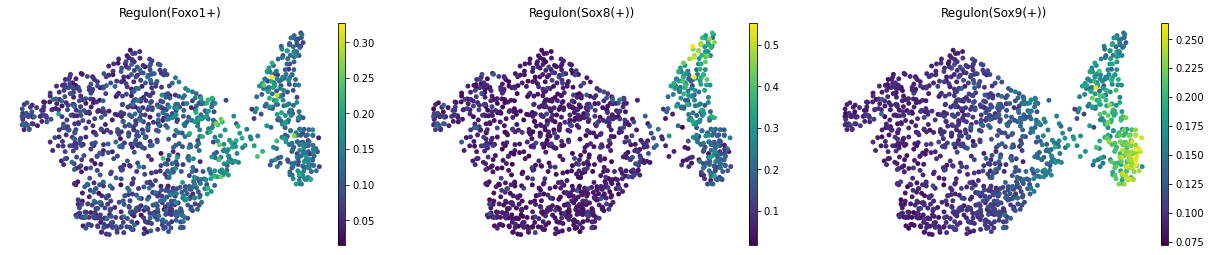

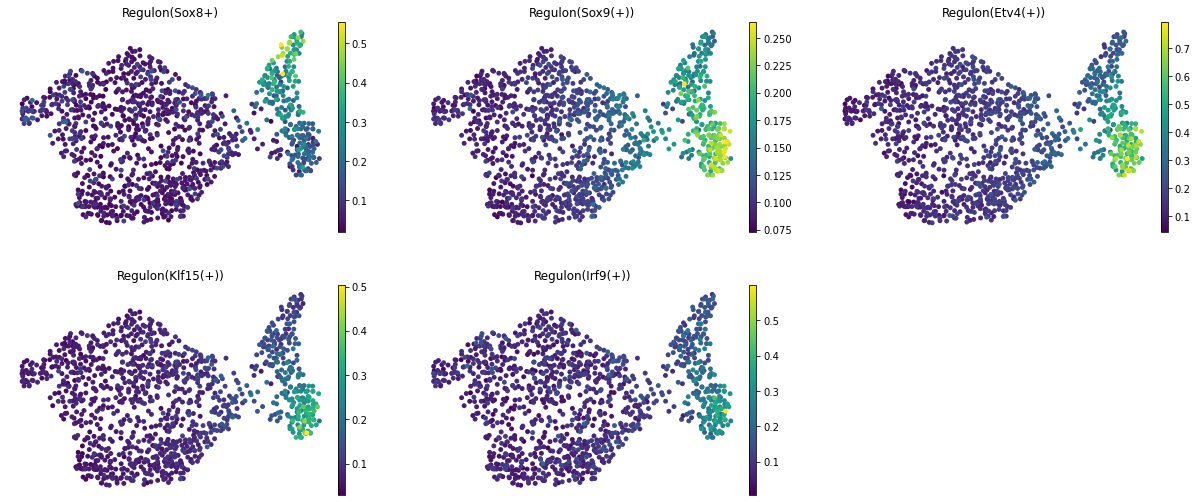

In [ ]:
N_COLORS = len(adata.obs['SCT_snn_res.0.6'])
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

#plot the activity of the regulon of interest
sc.pl.umap(adata, color=['Regulon(Sox8(+))', "Regulon(Sox9(+))", "Regulon(Foxo1(+))", "Regulon(Lhx1(+))"],
           title=['Regulon(Sox8(+))', "Regulon(Sox9(+))", "Regulon(Foxo1(+))", "Regulon(Lhx1(+))"], ncols=4, use_raw=False, palette=COLORS, cmap='viridis', frameon = False)
